In [1]:
import os
# pyopencl will use the GPU on my Macbook Pro
# os.environ['PYOPENCL_CTX'] = '1:2'

# pyopencl will use the GPU on my iMac
os.environ['PYOPENCL_CTX'] = '0:1'

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from refnx.reflect import SLD, Structure, ReflectModel, use_reflect_backend
from refnx.analysis import Parameter, Objective, CurveFitter
from refnx.dataset import ReflectDataset
from tof_simulator import ReflectSimulator
from parabolic_brush import ParabolicBrush

In [3]:
si = SLD(2.07)
sio2 = SLD(3.47)
dtol = SLD(5.6)
polymer = SLD(1.4)

# adsorbed amount
gamma = Parameter(95., 'adsorbed amount')
# roughness between brush and preceding layer
lrough = Parameter(10., 'left roughness')

# same brush as that in Karim1994.
brush = ParabolicBrush(polymer, 0.175, gamma, 1.0, 150, lrough, microslab_max_thickness=1)

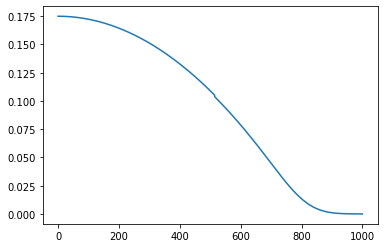

In [4]:
z = np.linspace(0, 1000, 1001)
vfp = brush.volume_fraction(z)
plt.plot(z, vfp);

In [5]:
s = si | sio2(15, 3) | brush | dtol(0, 3)
s.contract = 1.5
model = ReflectModel(s, bkg=5e-7, dq=4.97)

In [6]:
a0 = ReflectSimulator(model, 0.8, rebin=2.5)
a1 = ReflectSimulator(model, 3.5, rebin=2.5)

/Users/andrew/miniconda3/envs/dev3/lib/python3.8/site-packages/refnx/reduce/platypusnexus.py:438: RuntimeWarning: Setting default pixel size to 1.177
  warnings.warn(


In [7]:
with use_reflect_backend('pyopencl'):
    a0.sample_direct(1500000)
    a1.sample_direct(1500000)

    a0.sample(8000000)
    for i in range(700):
        a1.sample(1000000)
        if not i % 50:
            print(i)

0
50
100
150
200
250
300
350
400
450
500
550
600
650


In [34]:
import multiprocessing
import pickle
pickle.dumps(a1)

KeyboardInterrupt: 

In [8]:
d0 = a0.reflectivity
d1 = a1.reflectivity
d0 += d1

In [9]:
# set resolution of model (for constant dq/q smearing)
model.dq.value = np.mean(d0.x_err / d0.x) * 100

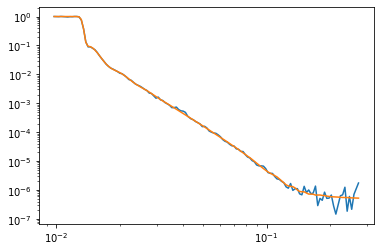

In [10]:
d0.save('karim_simulation.dat')
plt.plot(d0.x, d0.y)
plt.plot(d0.x, model(d0.x))
plt.yscale('log')
plt.xscale('log');
# plt.xlim(0.01, 0.02)
# plt.ylim(0.1, 1.1);

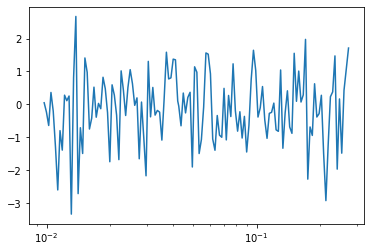

In [11]:
plt.plot(d0.x, (d0.y - model(d0.x))/d0.y_err)
plt.xscale('log')

In [12]:
d0 = ReflectDataset('karim_simulation.dat')

In [18]:
import FreeformVFP

In [19]:
# a left slab for an interior layer
# we use such a layer to make a roughness between it and
# the preceding layer
lslab = polymer(thick=20, rough=lrough)
lslab.vfsolv.value = 0.5

fvp = FreeformVFP.FreeformVFP(95, [0.5, 0.5, 0.5], [0.1, 0.01, 0.01, 0.01], polymer, left_slabs=[lslab])

In [20]:
# create a modelling structure using our FreeformVFP
s1 = si | sio2(10, 2) | lslab | fvp | dtol(0, 2)

# use profile contraction for speedier calculation
s1.contract = 1.5

# and a model
model1 = ReflectModel(s1, scale=1, bkg=1e-6, dq_type='constant')
model1.dq = np.mean(d0.x_err / d0.x) * 100

objective = Objective(model1, d0)

In [21]:
plt.plot(*fvp.profile(), label='starting point of FreeformVFP analysis')
plt.plot(z, vfp, label='Karim profile')
plt.legend()

TypeError: 'numpy.float64' object cannot be interpreted as an integer

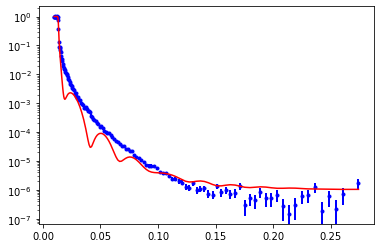

In [22]:
objective.plot()
plt.yscale('log')

In [23]:
objective.logp()

0.0

In [24]:
# set some fitting parameters and bounds
# sio2 layer
s1[1].thick.setp(vary=True, bounds=(5, 20))
s1[1].rough.setp(vary=True, bounds=(1, 6))

# the interior slab layer
lslab.thick.setp(vary=True, bounds=(15, 30))
lslab.rough.setp(vary=True, bounds=(1, 15))
lslab.vfsolv.setp(vary=True, bounds=(0, 1))

# set limits on knot spacing:
for p in fvp.dzf:
    p.setp(vary=True, bounds=(0.01, 0.3))

# set limits on vf:
for p in fvp.vff:
    p.setp(vary=True, bounds=(0.05, 0.8))

# set limits on adsorbed amount (use +/- ~5%)
fvp.adsorbed_amount.setp(vary=True, bounds=(92, 98))

# roughness of d2o/brush (probably won't be sensitive to this)
s1[-1].rough.setp(vary=True, bounds=(1, 5))

model1.scale.setp(vary=True, bounds=(0.95, 1.05))
model1.bkg.setp(vary=True, bounds=(1e-8, 1e-6))

In [25]:
fitter = CurveFitter(objective)

In [26]:
fitter.fit('differential_evolution', target='nlpost');

0it [00:00, ?it/s]/Users/andrew/Documents/Andy/programming/refnx-models/platypus-simulate/FreeformVFP.py:286: RuntimeWarning: extent > 10000, perfoming refl. calc on first 10000A.
  warnings.warn('extent > %d, perfoming refl. calc on first %dA.' %
81it [00:51,  1.71it/s]/Users/andrew/Documents/Andy/programming/refnx-models/platypus-simulate/FreeformVFP.py:153: RuntimeWarning: divide by zero encountered in double_scalars
  extent = difference / interpolator.integrate(0, 1)
81it [00:51,  1.57it/s]


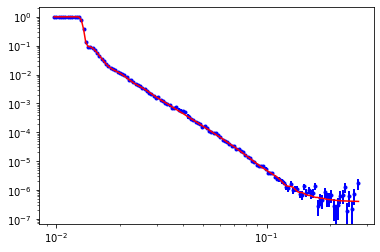

In [31]:
objective.plot()
plt.yscale('log')
plt.xscale('log')

In [28]:
model1.threads = 1
fitter.initialise(pos='jitter')
fitter.sample(1000);

100%|██████████| 1000/1000 [02:36<00:00,  6.40it/s]


In [ ]:
fitter.reset()
fitter.sample(5, nthin=500);

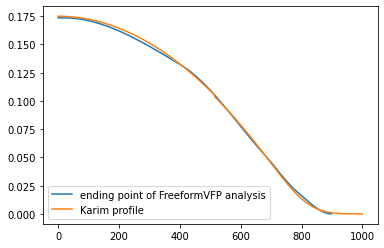

In [29]:
plt.plot(*fvp.profile(), label='ending point of FreeformVFP analysis')
plt.plot(z, vfp, label='Karim profile')
plt.legend();

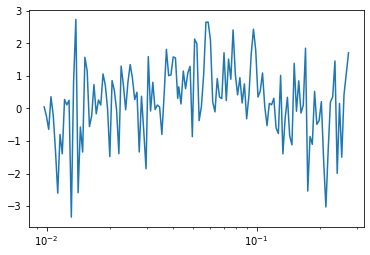

In [30]:
plt.plot(d0.x, (d0.y - model(d0.x))/d0.y_err)
plt.xscale('log')